# ANNRegularGDBackpropagation Demo

## Table of Contents

- [Introduction](#Intro)
- [Function Approximation](#Fapprox)
- [Non-Linear Binomial Classification](#nlbc)
- [Non-Linear Multiclass Classfication](#nlmc)
- [Good Ol' Iris Dataset](#goir)

## Introduction <a name="intro" > </a>

This notebook shows the functionality of the class `ANNRegularGDBackpropagation`, which can be used to create a Feedforward Artificial Neural Network with any number of Hidden Layers and any number of neurons on each layer, and also with any valid transfer functions. The neurons of the Output Layer are given by the particular problem, as well as the number of inputs. The ANN learns by a `.fit()` method, which implements the regular (slow) Stochastic/Batch Gradient Descent [Backpropagation](https://en.wikipedia.org/wiki/Backpropagation) algorithm. Then, `.predict()` and `.score()` shall be used. It also includes an [early stopping](https://en.wikipedia.org/wiki/Early_stopping) implementation (`early_stop=True` on `.fit()`) to prevent overfitting, together with a *Performance Index vs training epoch* visualization method. The class is designed in a way so that it can be used for regression, binomial and multinomial classification problems (with some target reshaping needed on the last case). The default method is stochastic, and *MSE* as the Performance Index.

Note that this implementation is the slowest version of the Backpropagation, but it still showcases the power of ANNs in a quite simple format.

In [1]:
import feed_forward_ann as ann  # https://github.com/PedroUria/DL/blob/master/feed_forward_ann/feed_forward_ann.py
from sketch_NN import sketch_simplified_nn  # https://github.com/PedroUria/DL/blob/master/sketch_NN/sketch_NN.py
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn import datasets
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [2]:
help(ann.ANNRegularGDBackProp)

Help on class ANNRegularGDBackProp in module feed_forward_ann:

class ANNRegularGDBackProp(builtins.object)
 |  A Feed-forward Artificial Neural Network with regular
 |  Batch/Stochastic Gradient Descend optimization by Backpropagation
 |  
 |  Methods defined here:
 |  
 |  __init__(self, x_shape, y_shape, hidden_layers_dim, random_state=0)
 |      Creates the desired ANN Architecture
 |      :param x_shape: input data's shape
 |      :param y_shape: target's shape (One-Hot encode more multiple classes)
 |      :param hidden_layers_dim: list containing the number of neurons of each Hidden Layer
 |      example: [S1-S2-...SM-1] (S0 is det. by x_shape and SM by y_shape)
 |      :param random_state: random seed
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  fit(self, x_train, y_train, layers_transfer_func, layers_transfer_func_der, n_epochs=1000, alpha=0.01, print_time=True, batch=False, perf_index='MSE', early_stop=False, stop=False, stop_crit=5, x_val=None, y_val=None)
 | 

## Function Approximation <a name="Fapprox" > </a>

Let's use the class to approximate the following function

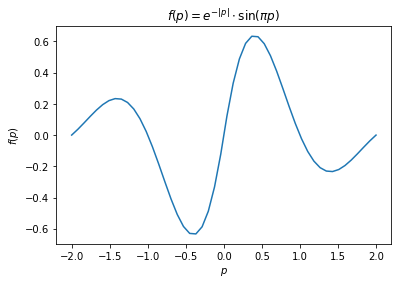

In [3]:
def f_to_approx(p):
    return np.exp(-abs(p)) * np.sin(np.pi * p)

# Creates the interval in which to approximate the function
p = np.linspace(-2, 2).reshape(-1, 1)
# Plots the function
plt.title("$f(p) = e^{-|p|} \cdot \sin(\pi p)$")
plt.ylabel("$f(p)$")
plt.xlabel("$p$")
plt.plot(p, f_to_approx(p))
plt.show()

In [4]:
# Creates the interval in which to approximate the function
p = np.linspace(-2, 2).reshape(-1, 1)
# Creates 1-10-1 ANN Architecture (the parameters aren't initialized until calling the .fit() method
nn = ann.ANNRegularGDBackProp(p.shape, f_to_approx(p).shape, [10], random_state=0)
nn.structure

'1-10-1'

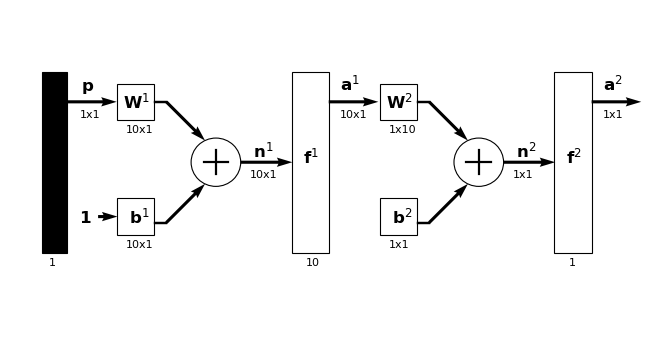

In [5]:
st = nn.structure.split("-")
st = [int(dim) for dim in st]
sketch_simplified_nn(st[0], st[1:])

The training process took 31.96 seconds


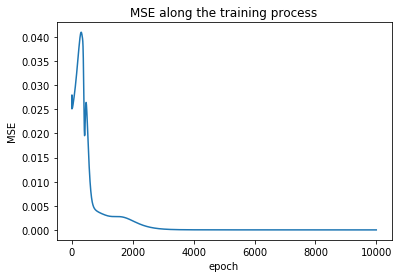

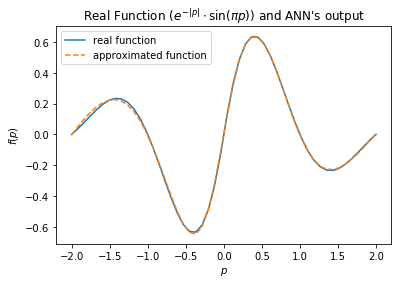

In [6]:
# Trains the ANN, using logsigmoid on the Hidden Layer and purelin on the Outer Layer
nn.fit(p, f_to_approx(p), [ann.logsigmoid, ann.purelin], [ann.logsigmoid_der, ann.purelin_der], n_epochs=10000, alpha=0.07)
# Visualizes the MSE along the training process
nn.viz_train_error()

def compare_with_real():
    # Predicts the values of f(p)
    pred = nn.predict(p)
    # Shows the results
    plt.title("Real Function ($e^{-|p|} \cdot \sin(\pi p)$) and ANN's output")
    plt.xlabel("$p$")
    plt.ylabel("$f(p)$")
    plt.plot(p, f_to_approx(p), label="real function")
    plt.plot(p, pred, linestyle="dashed", label="approximated function")
    plt.legend()
    plt.show()
    
compare_with_real()

Let's try it with two hidden layers and 4 and 2 neurons, respectively

The training process took 47.13 seconds


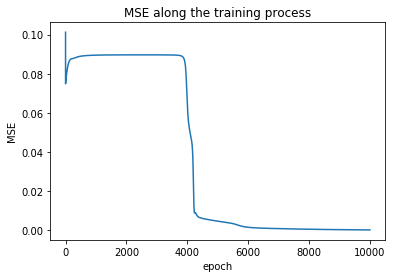

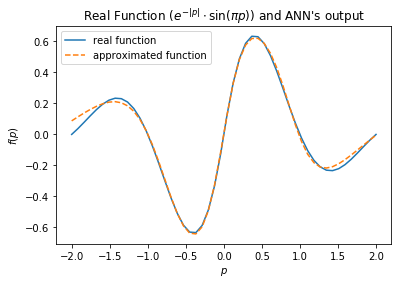

In [7]:
nn = ann.ANNRegularGDBackProp(p.shape, f_to_approx(p).shape, [4, 2], random_state=0)
nn.fit(p, f_to_approx(p), [ann.logsigmoid, ann.logsigmoid, ann.purelin],
        [ann.logsigmoid_der, ann.logsigmoid_der, ann.purelin_der], n_epochs=10000, alpha=0.07)
nn.viz_train_error()
compare_with_real()

Not bad, but actually **a two layer network with enough *sigmoids* on the Hidden Layer can approximate almost any function**. 2 Hidden Layers are not needed. Note that in both cases, our MSE increased along some intervals of the training process. This is because the stochastic approach updates the parameters after getting the error for each sample, instead of waiting until going through all the samples (batch). That is, the weights are always updated so that the error is decreased for the particular sample, but this does not guarantee that the overal MSE is decreased in all the iterations. Let's try with batch

The training process took 28.12 seconds


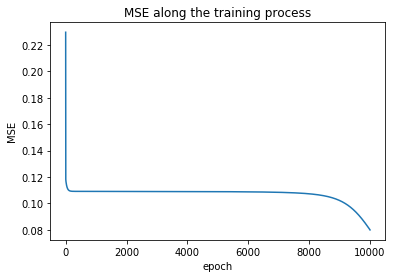

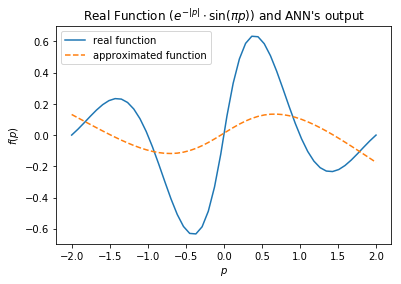

In [8]:
nn = ann.ANNRegularGDBackProp(p.shape, f_to_approx(p).shape, [10], random_state=0)
nn.fit(p, f_to_approx(p), [ann.logsigmoid, ann.purelin], [ann.logsigmoid_der, ann.purelin_der], n_epochs=10000, alpha=0.07, batch=True)
nn.viz_train_error()
compare_with_real()

However, batch is clearly slower... let's try with more iterations

The training process took 96.27 seconds


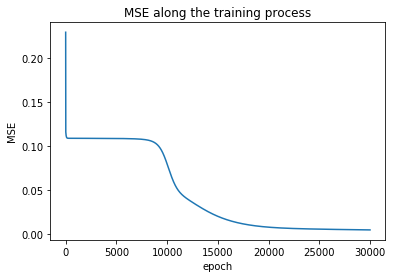

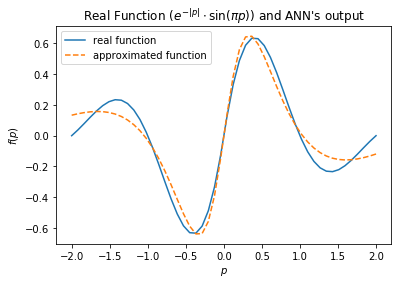

In [9]:
nn.fit(p, f_to_approx(p), [ann.logsigmoid, ann.purelin], [ann.logsigmoid_der, ann.purelin_der], n_epochs=30000, alpha=0.07, batch=True)
nn.viz_train_error()
compare_with_real()

## Non-Linear Binomial Classification <a name="nlbc" > </a>

Let's move to a non linearly separable classification problem with two class labels. The data is shown below

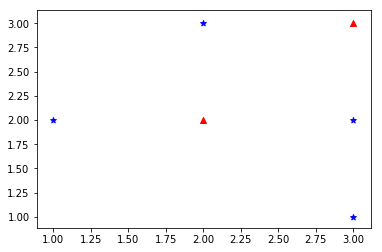

In [39]:
x = np.array([[1, 2], [2, 3],
             [3, 2], [3, 1],
             [2, 2], [3, 3]])
y = np.array([[1], [1], [1], [1], [0], [0]])

plt.scatter(x[:4, 0], x[:4, 1], marker="*", color="b")
plt.scatter(x[4:, 0], x[4:, 1], marker="^", color="r")
plt.show()

Now we will use *logsigmoid* on the Output Layer, and *ReLU* on the Hidden Layer. Furthermore, two *ReLu* neurons on the Hidden Layer should (actually must) be enough

The training process took 5.22 seconds


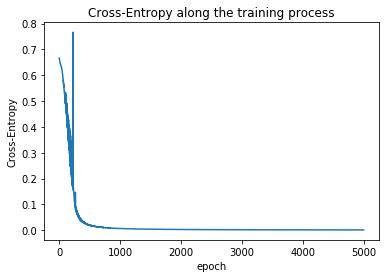

real: 1 pred: 0.9980575348956099
real: 1 pred: 0.9980575348956099
real: 1 pred: 0.9996784999015056
real: 1 pred: 0.9999999999873082
real: 0 pred: 0.0009518070931016526
real: 0 pred: 0.00012269587536646714


In [11]:
nn = ann.ANNRegularGDBackProp(x.shape, y.shape, [2], random_state=0)
nn.fit(x, y, [ann.poslin, ann.logsigmoid], [ann.poslin_der, ann.logsigmoid_der], n_epochs=5000, alpha=0.07, perf_index="Cross-Entropy")
nn.viz_train_error()
pred = nn.predict(x)
for i in range(y.shape[0]):
    print("real:", y[i][0], "pred:", pred[i][0])

In [12]:
nn.score(x, y)

1.0

The training process took 5.72 seconds


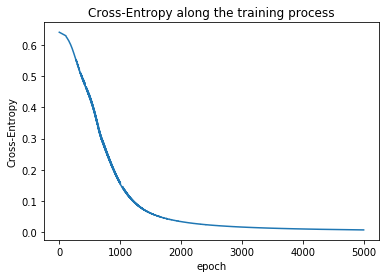

real: 1 pred: 0.9842656205832618
real: 1 pred: 0.98404474246166
real: 1 pred: 0.9963194008112136
real: 1 pred: 0.9999999824878619
real: 0 pred: 0.010997253910642952
real: 0 pred: 0.0012815701076753449


In [40]:
nn = ann.ANNRegularGDBackProp(x.shape, y.shape, [2], random_state=0)
nn.fit(x, y, [ann.poslin, ann.logsigmoid], [ann.poslin_der, ann.logsigmoid_der], n_epochs=5000, alpha=0.07, perf_index="Cross-Entropy", batch=True)
nn.viz_train_error()
pred = nn.predict(x)
for i in range(y.shape[0]):
    print("real:", y[i][0], "pred:", pred[i][0])

## Non-Linear Multiclass Classification <a name="nlmc" > </a>

Up until now, we only needed one neuron on the Output Layer. However, when we have more than two classes, we will need more neurons. Let's say we have 3 classes, as follows

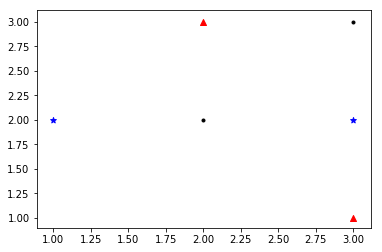

In [13]:
data = np.array([[1, 2, 0],
                 [3, 2, 1],
                 [2, 3, 0],
                 [3, 1, 1],
                 [2, 2, 2],
                 [3, 3, 2]])
x = data[:, :2]
y = data[:, 2]
plt.scatter(x[:2, 0], x[:2, 1], marker="*", color="b")
plt.scatter(x[2:4, 0], x[2:4, 1], marker="^", color="r")
plt.scatter(x[4:, 0], x[4:, 1], marker=".", color="k")
plt.show()

y_encoded = np.array([[[1],
                       [0],
                       [0]],
                      [[0],
                       [1],
                       [0]],
                      [[1],
                       [0],
                       [0]],
                      [[0],
                       [1],
                       [0]],
                      [[0],
                       [0],
                       [1]],
                      [[0],
                       [0],
                       [1]]
                      ])

We are going to use *softmax* on the Output Layer. That is why our target is encoded as `y_encoded` (One-Hot Encoding). Thus, we will be using 3 *softmax* neurons on the Output Layer. On the Hidden Layer, let's use two *ReLu* neurons on the Hidden Layer

The training process took 1.4 seconds


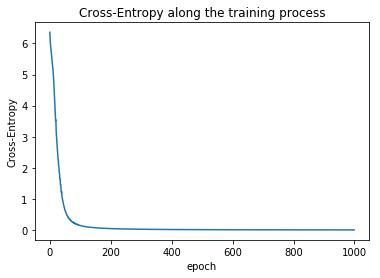


sample 0

real: [1] pred: [1.]
real: [0] pred: [0.]
real: [0] pred: [0.]

sample 1

real: [0] pred: [0.]
real: [1] pred: [0.999]
real: [0] pred: [0.001]

sample 2

real: [1] pred: [0.999]
real: [0] pred: [0.]
real: [0] pred: [0.001]

sample 3

real: [0] pred: [0.]
real: [1] pred: [1.]
real: [0] pred: [0.]

sample 4

real: [0] pred: [0.002]
real: [0] pred: [0.001]
real: [1] pred: [0.997]

sample 5

real: [0] pred: [0.]
real: [0] pred: [0.]
real: [1] pred: [1.]


In [14]:
nn = ann.ANNRegularGDBackProp(x.shape, y_encoded.shape, [2])
nn.fit(x, y_encoded, [ann.poslin, ann.stablesoftmax], [ann.poslin_der, ann.softmax_der], n_epochs=1000, alpha=0.07, perf_index="Cross-Entropy")
nn.viz_train_error()
pred = nn.predict(x)
for i in range(y_encoded.shape[0]):
    print("\nsample " + str(i) + "\n")
    for j in range(y_encoded.shape[1]):
        print("real:", y_encoded[i, j], "pred:", np.round(pred[i, j], 3))

In [15]:
nn.score(x, y_encoded)

1.0

## Good Ol' Iris Dataset <a name="goir" > </a>

Finally, let's use the infamous Iris Dataset, which needs no introduction

In [16]:
data = datasets.load_iris()
iris = pd.DataFrame(data["data"], columns=data["feature_names"])
iris["class"] = data["target"]

In [17]:
iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [18]:
X = iris.drop("class", axis=1)
y = iris["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

# We need to One-Hot encode the target and reshape it to the suitable form
y_train = pd.get_dummies(y_train).values
y_train = y_train.reshape(y_train.shape[0], 3 , 1)
y_test = pd.get_dummies(y_test).values
y_test = y_test.reshape(y_test.shape[0], 3 , 1)

The training process took 18.23 seconds


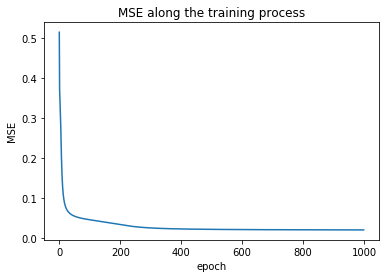

In [19]:
nn = ann.ANNRegularGDBackProp(X_train.shape, y_train.shape, [2])
nn.fit(X_train, y_train, [ann.poslin, ann.stablesoftmax], [ann.poslin_der, ann.softmax_der], n_epochs=1000, alpha=0.07)
nn.viz_train_error()

As we have many samples, let's only print those on which our ANN was wrong

In [20]:
nn.score(X_test, y_test, print_wrong=True)


sample 15

real: [0] pred: [0.002]
real: [0] pred: [0.998]
real: [1] pred: [0.]

sample 16

real: [0] pred: [0.]
real: [1] pred: [0.18]
real: [0] pred: [0.82]

sample 24

real: [0] pred: [0.001]
real: [0] pred: [0.997]
real: [1] pred: [0.002]


0.933

Finally let's compare with the performance on the training set

In [21]:
nn.score(X_train, y_train, print_wrong=True)


sample 98

real: [0] pred: [0.002]
real: [0] pred: [0.998]
real: [1] pred: [0.]


0.99

So our ANN overfitted quite a bit... let's try the simplest method in order to prevent this

### Early Stopping

In [22]:
# Gets our early train and test split first (need to do it again because we don't want to standardize X_train yet)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Gets the training and validation sets from X_train and y_train
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0, stratify=y_train)

std = StandardScaler()
X_train_train = std.fit_transform(X_train_train)
X_train_val = std.transform(X_train_val)

# We need to One-Hot encode the target and reshape it to the suitable form
y_train_train = pd.get_dummies(y_train_train).values
y_train_train = y_train_train.reshape(y_train_train.shape[0], 3 , 1)
y_train_val = pd.get_dummies(y_train_val).values
y_train_val = y_train_val.reshape(y_train_val.shape[0], 3 , 1)

In [23]:
# Note that in this case we don't need to initialize the ANN again
# The structure will be the same, and both the fit and fit_early_stopping
# methods will intialize the parameters when called
best_epoch = nn.fit(X_train_train, y_train_train, [ann.poslin, ann.stablesoftmax], [ann.poslin_der, ann.softmax_der],
                    x_val=X_train_val, y_val=y_train_val, n_epochs=1000, alpha=0.07, early_stop=True,
                    stop=True, stop_crit=5)

The training process took 0.52 seconds


In [24]:
best_epoch

33

In [25]:
nn.perf_index.shape[0]

33

So the training stopped at 33 epochs. By looking at 

The training process took 0.76 seconds


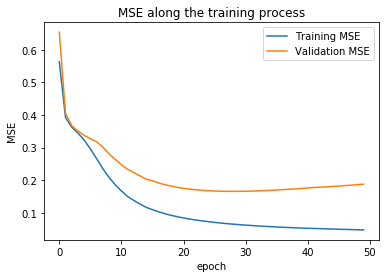

In [26]:
best_epoch = nn.fit(X_train_train, y_train_train, [ann.poslin, ann.stablesoftmax],
                    [ann.poslin_der, ann.softmax_der], n_epochs=50, alpha=0.07,
                    x_val=X_train_val, y_val=y_train_val, early_stop=True)
nn.viz_train_error(plot_val=True)

In [27]:
nn.perf_index_val[25:40]

array([0.16672518, 0.16611615, 0.16576999, 0.16565983, 0.16576187,
       0.16605493, 0.16651999, 0.16713994, 0.16789927, 0.16878389,
       0.169781  , 0.17087886, 0.1720668 , 0.17333503, 0.17467457])

it makes sense, although stopping at about 28 epochs would have been the best. The condition in `.fit(, early_stop=True, stop=True)` to actually break the loop could be improved, but at least it serves to stop the loop close to the best epoch, and then the best epoch can be visualized as done above. So let's choose `n_epochs=28`. 

Note that for a very long training process this is not feasible, because the training would need to be done twice. 

In [28]:
nn.fit(X_train_train, y_train_train,
       [ann.poslin, ann.stablesoftmax], [ann.poslin_der, ann.softmax_der],
       n_epochs=28, alpha=0.07)

The training process took 0.37 seconds


In [29]:
nn.score(X_train_train, y_train_train)

0.986

In [30]:
nn.score(X_train_val, y_train_val)

0.906

Alright, let's do the same for our same train test split, and compare

In [31]:
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

# We need to One-Hot encode the target and reshape it to the suitable form
y_train = pd.get_dummies(y_train).values
y_train = y_train.reshape(y_train.shape[0], 3 , 1)
y_test = pd.get_dummies(y_test).values
y_test = y_test.reshape(y_test.shape[0], 3 , 1)

In [32]:
nn.fit(X_train, y_train, [ann.poslin, ann.stablesoftmax], [ann.poslin_der, ann.softmax_der], n_epochs=28, alpha=0.07)

The training process took 0.54 seconds


In [33]:
nn.score(X_test, y_test, print_wrong=True)


sample 16

real: [0] pred: [0.015]
real: [1] pred: [0.438]
real: [0] pred: [0.548]


0.978

Indeed, the performance on the traning set increased from 0.933 accuracy to 0.978 accuracy! Before, our ANN was too complex. 

In [34]:
nn.score(X_train, y_train, print_wrong=True)


sample 31

real: [0] pred: [0.008]
real: [1] pred: [0.297]
real: [0] pred: [0.695]

sample 94

real: [0] pred: [0.018]
real: [1] pred: [0.485]
real: [0] pred: [0.497]

sample 98

real: [0] pred: [0.027]
real: [0] pred: [0.63]
real: [1] pred: [0.342]


0.971

Note that our "individual" predictions are worse, that is, we are assigning bigger probabilities than before to false classes, even when they are lower than the probability we assign to the true class. However, in this case, this is the price for generalization, and it's actually a good result, as our accuracy on the testing set has improved a lot, and on the training set is still very good.

Finally, let's cross-validate

In [35]:
from sklearn.model_selection import StratifiedKFold


skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 0)
test_scores, train_scores = [], []
std = StandardScaler()
it = 0
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    std = StandardScaler()
    X_train = std.fit_transform(X_train)
    X_test = std.transform(X_test)

    # We need to One-Hot encode the target and reshape it to the suitable form
    y_train = pd.get_dummies(y_train).values
    y_train = y_train.reshape(y_train.shape[0], 3 , 1)
    y_test = pd.get_dummies(y_test).values
    y_test = y_test.reshape(y_test.shape[0], 3 , 1)

    nn.fit(X_train, y_train, [ann.poslin, ann.stablesoftmax], [ann.poslin_der, ann.softmax_der], n_epochs=28, alpha=0.07)
    test_scores.append(nn.score(X_test, y_test))
    train_scores.append(nn.score(X_train, y_train))

The training process took 0.68 seconds
The training process took 0.64 seconds
The training process took 0.64 seconds
The training process took 0.64 seconds
The training process took 0.64 seconds
The training process took 0.64 seconds
The training process took 0.65 seconds
The training process took 0.65 seconds
The training process took 0.65 seconds
The training process took 0.64 seconds


In [36]:
test_scores

[1.0, 0.867, 0.867, 1.0, 1.0, 0.933, 1.0, 1.0, 1.0, 1.0]

In [37]:
train_scores

[0.963, 0.978, 0.978, 0.963, 0.963, 0.97, 0.963, 0.963, 0.963, 0.963]

This is definitelly a good result. Last but not least, let's compare with a multinomial Logistic Regression model

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
std = StandardScaler()
X_train_train = std.fit_transform(X_train_train)
X_train_val = std.transform(X_train_val)

lr = LogisticRegression(random_state=0, solver="liblinear", multi_class="ovr")
start = time.time()
lr.fit(X_train, y_train)
print("The training process took", round(time.time() - start, 3), "seconds")
lr.score(X_test, y_test)

The training process took 0.003 seconds


0.9777777777777777

As we can see, the accuracy is about the same, but the training time is 3 orders of magnitud lower than for the ANN. ANNs shine for complex data for which the usual Machine Learning algorithms are not able to capture the true pattern. Still, the training process can be very long, specially when using the regular SGD Backpropagation method implemented here, and without using GPUs.